<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

## Questions:
#Do I take the Conv output before or after ReLU

on device: cuda


In [3]:
# try:
#   import einops
# except:
#   !pip install einops
# from einops import rearrange, reduce, repeat

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.5 MB/s eta 0:00:00
[INFO] Couldn't find torchinfo... installing it.


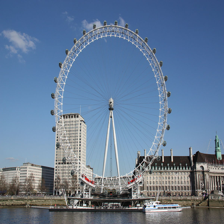

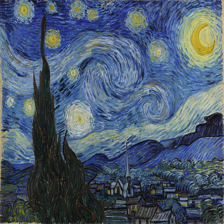

In [5]:
content_image = Image.open("/content/LondonEye.jpg").resize((224, 224))
content_image.show()
style_image = Image.open("/content/StarryNight.jpg").resize((224, 224))
style_image.show()

In [6]:
content = torch.tensor(np.asarray(content_image)/255.).type(torch.float).permute(2, 0, 1).unsqueeze(dim=0).to(device)
style = torch.tensor(np.asarray(style_image)/255.).type(torch.float).permute(2, 0, 1).unsqueeze(dim=0).to(device)
content.shape, style.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [7]:
weights = torchvision.models.VGG19_Weights.IMAGENET1K_V1 #  height=224, width=224
vgg_pretrained_model = torchvision.models.vgg19(weights=weights).to(device)

#Deleting end layers to reduce model computational overhead
for i in range(29, 37): vgg_pretrained_model.features[i] = nn.Sequential()
vgg_pretrained_model.avgpool = nn.Sequential()
vgg_pretrained_model.classifier = nn.Sequential()
# print(vgg_pretrained_model)

#Register hook
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output #.detach()
    return hook

output_idxs = [0, 5, 10, 19, 28]
for conv_num, i in enumerate(output_idxs):
  vgg_pretrained_model.features[i].register_forward_hook(get_activation('conv'+str(conv_num+1)))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [14]:
class NeuralStyleTransfer(nn.Module):
  def __init__(self, vgg_model, generated_size=(1, 3, 224, 224)):
    super().__init__()

    self.generated = nn.Parameter(torch.rand(generated_size))
    self.vgg = vgg_model

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.vgg(self.generated)

def calculate_gram(x):
  """Calculate gram matrix

  Parameters:
    x(torch.Tensor) --immediate output model
  
  Outputs (c, c) dimensional gram matrix
  """
  x = torch.flatten(x, start_dim=1,end_dim=2) # 'c h w -> c (h w)'
  return x @ x.T 

def calculate_loss(activations, content_layer_idx = 0, style_layers_to_use=0):
  """Calculates content and style loss

  activations (dict of torch.Tensor's) --outputs from the immediate layers in the network for content, style & generated images
  content_layer_idx (int 0-4) --layer index to use for context features
  
  Returns content and style loss, (torch.Tensor with grad)
  """
  # for key in activations: print(key, activations[key].shape)
  loss_fn = nn.MSELoss(reduction='sum') # as described in paper


  content_outputs = []
  style_outputs = []
  generated_outputs = []
  for key in activations:
    content_outputs.append(activations[key][0])
    style_outputs.append(activations[key][1])
    generated_outputs.append(activations[key][2])

   # possibly flatten first (for clarity, although I don't think it will change the output)

  content_loss = loss_fn(torch.flatten(content_outputs[content_layer_idx], start_dim=1,end_dim=2), torch.flatten(generated_outputs[content_layer_idx], start_dim=1,end_dim=2))


  style_loss = 0
  for i in range(style_layers_to_use):
    #Create Gram matrix for Style and generated Image
    s = torch.flatten(style_outputs[i], start_dim=1,end_dim=2) # 'c h w -> c (h w)
    g = torch.flatten(generated_outputs[i], start_dim=1,end_dim=2)
    scale_factor = 1/((2*s.shape[0]*s.shape[1])**2) #1/(4N_l^2M_l^2)

    layer_loss = loss_fn(s@s.T, g@g.T) # (c c)
    print(layer_loss, scale_factor)
    style_loss+= scale_factor*layer_loss

  return content_loss, style_loss

In [18]:
### Inputs & Hyperparameters
alpha, beta = 0.9, 0.1
learning_rate = 2e-3
epochs = 2000

model = NeuralStyleTransfer(vgg_pretrained_model).to(device)
optimizer = torch.optim.SGD([model.generated], lr=learning_rate)
model.train()
for epoch in range(epochs):   
  input = torch.concat((content, style, model.generated), dim=0)
  _ = vgg_pretrained_model(input)

  content_loss, style_loss = calculate_loss(activations, content_layer_idx=0)
  loss = alpha*content_loss #+ beta*style_loss
  if epoch % 100 == 0: 
    print(f"\nEpoch: {epoch} | {loss.item():.4f}")
    print("loss", loss, "c:", content_loss, "s:", style_loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


Epoch: 0 | 286967.9688
loss tensor(286967.9688, device='cuda:0', grad_fn=<MulBackward0>) c: tensor(318853.3125, device='cuda:0', grad_fn=<MseLossBackward0>) s: 0

Epoch: 100 | 2099.9910
loss tensor(2099.9910, device='cuda:0', grad_fn=<MulBackward0>) c: tensor(2333.3232, device='cuda:0', grad_fn=<MseLossBackward0>) s: 0

Epoch: 200 | 833.9251
loss tensor(833.9251, device='cuda:0', grad_fn=<MulBackward0>) c: tensor(926.5835, device='cuda:0', grad_fn=<MseLossBackward0>) s: 0

Epoch: 300 | 493.7092
loss tensor(493.7092, device='cuda:0', grad_fn=<MulBackward0>) c: tensor(548.5658, device='cuda:0', grad_fn=<MseLossBackward0>) s: 0

Epoch: 400 | 331.0350
loss tensor(331.0350, device='cuda:0', grad_fn=<MulBackward0>) c: tensor(367.8167, device='cuda:0', grad_fn=<MseLossBackward0>) s: 0

Epoch: 500 | 237.5280
loss tensor(237.5280, device='cuda:0', grad_fn=<MulBackward0>) c: tensor(263.9200, device='cuda:0', grad_fn=<MseLossBackward0>) s: 0

Epoch: 600 | 178.0209
loss tensor(178.0209, device='c

KeyboardInterrupt: ignored

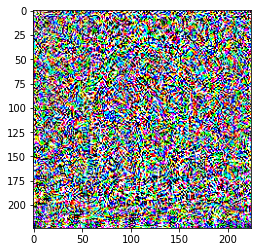

In [12]:
formatted_output = nn.functional.relu(model.generated.detach().cpu()[0].permute(1, 2, 0))
formatted_output[formatted_output > 1] = 1
plt.imshow(formatted_output)

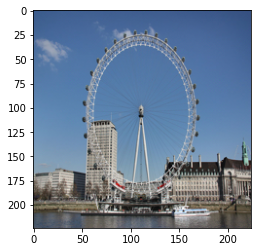

In [19]:
#conv1:
formatted_output = nn.functional.relu(model.generated.detach().cpu()[0].permute(1, 2, 0))
formatted_output[formatted_output > 1] = 1
plt.imshow(formatted_output)

In [ ]:
summary(vgg_pretrained_model, input_size=[1, 3, 224, 224], col_names =['input_size', 'output_size', 'num_params', 'trainable'])